In [1]:
"""
Experiments with CNNs/VAEs
"""
from ipywidgets import *
import tensorflow as tf
import vae_tests.tfutils as ut
import vae_tests.config as config
import numpy as np
import vae_tests.augmentation as aug
sess = tf.InteractiveSession()

"""
Utility functions from https://github.com/fastforwardlabs/vae-tf/blob/master/vae.py
"""
def sampleGaussian(mu, log_sigma):
        """(Differentiably!) draw sample from Gaussian with given shape, subject to random noise epsilon"""
        with tf.name_scope("sample_gaussian"):
            # reparameterization trick
            epsilon = tf.random_normal(tf.shape(log_sigma), name="epsilon")
            return mu + epsilon * tf.exp(log_sigma) # N(mu, I * sigma**2)


def crossEntropy(obs, actual, offset=1e-7):
    """Binary cross-entropy, per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
    with tf.name_scope("cross_entropy"):
        # bound by clipping to avoid nan
        obs_ = tf.clip_by_value(obs, offset, 1 - offset)
        return -tf.reduce_sum(actual * tf.log(obs_) +
                              (1 - actual) * tf.log(1 - obs_), 1)


def l1_loss(obs, actual):
    """L1 loss (a.k.a. LAD), per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
    with tf.name_scope("l1_loss"):
        return tf.reduce_sum(tf.abs(obs - actual) , 1)


def l2_loss(obs, actual):
    """L2 loss (a.k.a. Euclidean / LSE), per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
    with tf.name_scope("l2_loss"):
        return tf.reduce_sum(tf.square(obs - actual), 1)


def kullbackLeibler(mu, log_sigma):
    """(Gaussian) Kullback-Leibler divergence KL(q||p), per training example"""
    # (tf.Tensor, tf.Tensor) -> tf.Tensor
    with tf.name_scope("KL_divergence"):
        # = -0.5 * (1 + log(sigma**2) - mu**2 - sigma**2)
        return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)




In [2]:
from io import BytesIO
import PIL
from PIL import Image
from IPython.display import display, Image

def display_img_array(ima):  
  im = PIL.Image.fromarray(ima).convert('RGB')  
  bio = BytesIO()
  im.save(bio, format='png')
  display(Image(bio.getvalue(), format='png'))

In [3]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
@ops.RegisterGradient("MaxPoolWithArgmax")
def _MaxPoolWithArgmaxGrad(op, grad, some_other_arg):
  return gen_nn_ops._max_pool_grad(op.inputs[0],
                                   op.outputs[0],
                                   grad,
                                   op.get_attr("ksize"),
                                   op.get_attr("strides"),
                                   padding=op.get_attr("padding"),
                                   data_format='NHWC')

In [4]:

# Training Parameters
learning_rate   = 0.01 #0.001
training_epochs = 1000
batch_size      = 10
display_step    = 1

#build the graph


#the first dimension=None, it represents the batch size, can be any size
# graph
scope="shelf"
with tf.variable_scope(scope):
    x_in_depth = tf.placeholder(tf.float32, [None, 128, 128, 1])
    
    phase = tf.placeholder(tf.bool, name='phase_train')
   

    
    #-----------------------
    # encoder p(z|x)
    #-----------------------
    conv11 = ut.conv_layer_with_bn(
                    x_in_depth, [3, 3, 1, 32], phase, name="conv11")
     # see https://groups.google.com/a/tensorflow.org/forum/#!topic/discuss/vf8eH9YMwVA
    dyn_input_shape = tf.shape(conv11)
    in_batch = dyn_input_shape[0]
    pool1, pool1_indices = tf.nn.max_pool_with_argmax(
                    conv11, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME', name='pool1')        
    conv21 = ut.conv_layer_with_bn(
                    pool1, [3, 3, 32, 64], phase, name="conv21")
    pool2, pool2_indices = tf.nn.max_pool_with_argmax(
                    conv21, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')       
    conv31 = ut.conv_layer_with_bn(
                    pool2, [3, 3, 64, 128], phase, name="conv31")
    conv32 = ut.conv_layer_with_bn(
                    conv31, [3, 3, 128, 128], phase, name="conv32")
    pool3, pool3_indices = tf.nn.max_pool_with_argmax(
                    conv32, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool3')        
    conv41 = ut.conv_layer_with_bn(
                    pool3, [3, 3, 128, 256], phase, name="conv41")
    conv42 = ut.conv_layer_with_bn(
                    conv41, [3, 3, 256, 256], phase, name="conv42")
    pool4, pool4_indices = tf.nn.max_pool_with_argmax(
                    conv42, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool4')

    latent_variables = 9
    print('pool4')
    print(pool4.get_shape())
    dense = tf.reshape(pool4, [in_batch, pool4.get_shape().as_list()[1]*pool4.get_shape().as_list()[2]*256])
    print('dense')
    print(dense.get_shape())
    full = ut.full_layer_with_bn(dense, [dense.get_shape().as_list()[1], 256], phase, name="full")
    
    
    print('full')
    print(full.get_shape())
    #-----------------------
    #the latent variables   
    z_mean = ut.full_layer_with_bn(full, [full.get_shape().as_list()[1], latent_variables], phase, name="z_mean")        
    z_log_sigma = ut.full_layer_with_bn(full, [full.get_shape().as_list()[1], latent_variables], phase, name="z_log_sigma")       

   
    print('z_mean')
    print(z_mean.get_shape())   
    
    #---------------------------------
    # at this point define the KL loss
    #---------------------------------
    kl_loss = kullbackLeibler(z_mean, z_log_sigma)
    
    
    #-----------------------
    # decoder p(x|z)
    #-----------------------
    
    #first, need to sample from unit Gaussian and scale the result(reparametrization trick)
    gaussian_sampled = sampleGaussian(mu=z_mean, log_sigma=z_log_sigma)
    
    print('gaussian_sampled')
    print(gaussian_sampled.get_shape())    
    
    deconv_dense = ut.full_layer_with_bn(gaussian_sampled, [latent_variables, 256], phase, name="deconv4")   
    #deconv_dense = ut.full_layer_with_bn(gaussian_sampled, tf.pack([in_batch,pool4.get_shape()[1]*pool4.get_shape()[2]*pool4.get_shape()[3]]), phase, name="deconv4")   
      
    
    print('deconv_dense')
    print(deconv_dense.get_shape())
    
    full_deconv = ut.full_layer_with_bn(deconv_dense, [256, 8*8*256], phase, name="full_deconv")   
    
    
    deconv4 = tf.reshape(full_deconv, tf.pack([in_batch,8,8,256]))
    
    print('deconv4')
    print(deconv4.get_shape())
    
    #in_batch = tf.shape(deconv4)[0]#deconv4.get_shape()[0]
    ksize=5
    factor=2
    number_of_classes = int(int(deconv4.get_shape()[3]) / factor)
    in_features = deconv4.get_shape()[3].value
    deconv3 = ut.deconv_layer_koo(deconv4, [ksize, ksize, 256, 256], 
                                  tf.pack([in_batch,16, 16, 256]) , 
                                  stride=2, name="deconv3")
    
    print('deconv3')
    print(deconv3.get_shape())
    
    deconv2 = ut.deconv_layer_koo(deconv3, [ksize, ksize, 128, 256], 
                                  tf.pack([in_batch,32, 32, 128]) , 
                                  stride=2, name="deconv2")
    
    print('deconv2')
    print(deconv2.get_shape())
    
    deconv1 = ut.deconv_layer_koo(deconv2, [ksize, ksize, 64, 128], 
                                  tf.pack([in_batch,64, 64, 64]) ,                                  
                                  stride=2, name="deconv1")
  

    print('deconv1')
    print(deconv1.get_shape())
    x_reconstructed = ut.deconv_layer_koo(deconv1, [ksize, ksize, 1, 64], 
                                          tf.pack([in_batch,128, 128, 1]) , stride=2, name="x_reconstructed")
   
    



pool4
(?, 8, 8, 256)
dense
(?, 16384)
full
(?, 256)
z_mean
(?, 9)
gaussian_sampled
(?, 9)
deconv_dense
(?, 256)
deconv4
(?, 8, 8, 256)
deconv3
(?, ?, ?, ?)
deconv2
(?, ?, ?, ?)
deconv1
(?, ?, ?, ?)


In [5]:

#loss
print(x_reconstructed.get_shape())
#--------------------------------------------------------
# at this point define cross entropy, reconstruction loss
#--------------------------------------------------------
rec_loss = crossEntropy(x_reconstructed, x_in_depth)
cost = tf.reduce_mean(rec_loss + kl_loss, name="cost")

(?, ?, ?, ?)


In [6]:
#training initialisation
# Saver 
save_step = 10;
saver = tf.train.Saver(max_to_keep=training_epochs) 

#adam optimisation. Needs the cost function
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#corr = tf.equal(theta, y) # Count corrects
#accr = tf.reduce_mean(tf.cast(corr, tf.float32)) # Accuracy

# Do some optimizations
#init = tf.global_variables_initializer()
init = tf.initialize_all_variables()
sess = tf.Session()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.99)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#sess = tf.Session(config=tf.ConfigProto(
#      allow_soft_placement=True, log_device_placement=True))
sess.run(init, feed_dict={phase: True})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


['depth_map']
training...
   augmenting for training...
   done
[  4.23994923   8.08320808   4.26616716  10.96237183   5.20120907
   8.7430563    7.41275549   7.14467955   5.91650248   7.41275549]
(10, 128, 128, 1)


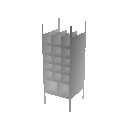

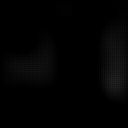

[  8.65381145  11.55103207   9.14713001   5.57637882   2.90733886
   3.73113298   2.48021936   9.24240685  10.36114025   9.24240685]
(10, 128, 128, 1)


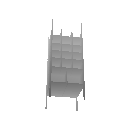

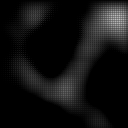

[ 10.03256989   7.01482964   5.08219147   2.8671217    9.93774033
   7.03900146  11.25521183   5.19793797   5.38446426   5.08219147]
(10, 128, 128, 1)


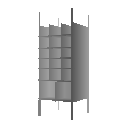

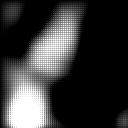

[  9.75632381   6.41943645   4.53004313   8.18579006  13.01732922
   6.97891903   6.97891903   2.17228222   7.75250673   4.8532815 ]
(10, 128, 128, 1)


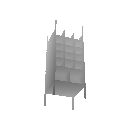

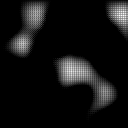

[  6.58356142   3.23701906   3.23701906  12.96403503   9.23323727
   2.68495989   8.60330963   6.21438122   4.26135969   6.49693155]
(10, 128, 128, 1)


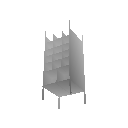

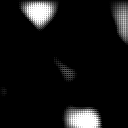

[  4.69341898   8.69661522  12.33506107   2.80054522   7.47294188
   4.5825429    7.49667978   0.95508212  11.32308483   5.59335136]
(10, 128, 128, 1)


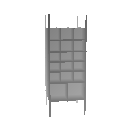

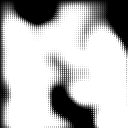

done
training...
   augmenting for training...
   done
[  3.6054635    9.15156651   7.78556395   8.70012856   7.01342344
   5.24282789   1.61021817  11.27419186  10.27852249   7.1916132 ]
(10, 128, 128, 1)


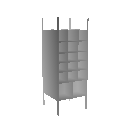

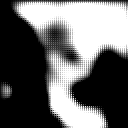

[ 10.52862167   1.31850374  12.13075352   3.5103929    9.64257145
   3.5103929   10.03929901   2.98380971   1.70799911   9.28382111]
(10, 128, 128, 1)


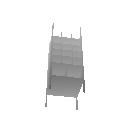

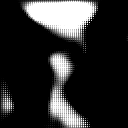

[  3.85477471  12.82456303   5.38887215   2.94857788   2.94857788
   7.00944901   4.97979593   8.17890739   6.98998785  11.39666843]
(10, 128, 128, 1)


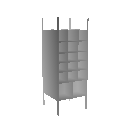

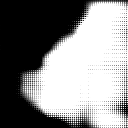

[  5.45707035   4.40616369   4.14457893   6.71994257   4.60577869
   4.14457893  12.16719723   7.69152737   1.19348788  12.42049026]
(10, 128, 128, 1)


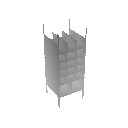

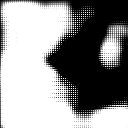

[  3.5855031    3.77165794   1.74324024  10.25363922   4.24713421
   7.54704952   8.98162365   2.96866632   8.83591652  12.28977394]
(10, 128, 128, 1)


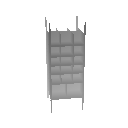

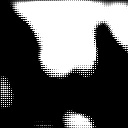

[  6.23035383  11.29532433  11.6476078    7.98050976   3.74241161
   9.52146339   4.95194435   6.95462751   7.10292578   6.6176157 ]
(10, 128, 128, 1)


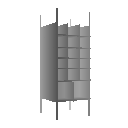

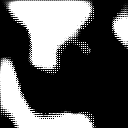

done
training...
   augmenting for training...
   done
[  8.24604797  11.42814922   8.43102741   6.78403664   9.57139874
   5.01959181   1.85161138   9.86271381   5.01959181   2.92269945]
(10, 128, 128, 1)


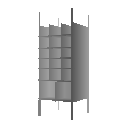

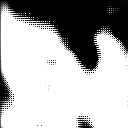

[  2.37002492   6.30855179  12.13905811   6.22719383   7.6890974
   4.43561459   6.22719383   4.51199389   1.37078261  12.46616077]
(10, 128, 128, 1)


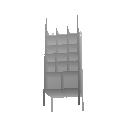

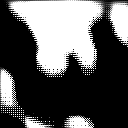

[  7.38446283  12.27972412   5.84552002  11.02036095   7.38446283
   5.84552002   1.95391941   2.60126257   9.52485466   5.45220995]
(10, 128, 128, 1)


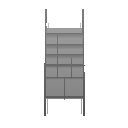

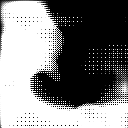

[  3.60953856   9.13488579  10.30630302   4.84386539   9.13488579
   1.4198916    9.20963097   8.13959503   9.20963097   9.34062099]
(10, 128, 128, 1)


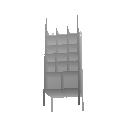

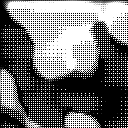

[  3.31429672   4.97323132   9.97315598  10.06492138   5.13860703
  10.42599678   6.11609888   7.30723763  10.42599678   3.0313096 ]
(10, 128, 128, 1)


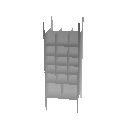

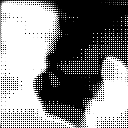

[  5.65799999   3.93701267   3.14246869   6.31621599   9.79927158
   9.90909481   2.5109725    4.71053457  11.22271538   9.01337242]
(10, 128, 128, 1)


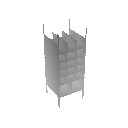

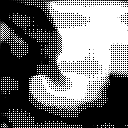

done
training...
   augmenting for training...
   done
[ 10.77853584   5.7153368    7.44607687   5.720788     7.9755621
  11.48476696   5.720788     0.3990947    3.75701141   6.54780769]
(10, 128, 128, 1)


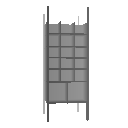

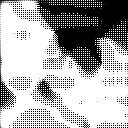

[ 11.16683578   5.53298998   7.31624508   3.04766035   1.34455884
   7.28979826   9.76036835   8.90620422   7.58092451   5.55229473]
(10, 128, 128, 1)


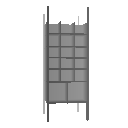

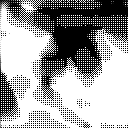

[  9.54825974   2.21915913   4.50468111   9.81934547   8.17061806
   2.33890247  10.02458382   5.45408106  10.02458382   9.94608688]
(10, 128, 128, 1)


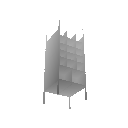

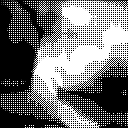

[  1.40988994   8.21583176  10.15477562   8.20627213   4.2498064
   7.36128998  10.73266888   8.98087978   5.67722607   5.95373774]
(10, 128, 128, 1)


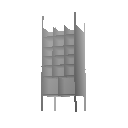

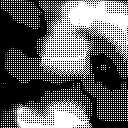

[ 11.60425568  11.10095406  10.15231323   4.61557007   5.03109598
  10.15231323   4.32376337   5.03109598   2.37401581   1.43950677]
(10, 128, 128, 1)


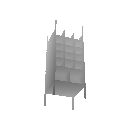

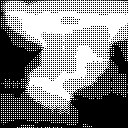

[  6.98875952  11.13503361   9.60377407   7.89654493   3.399508
   7.41131878   9.60377407   0.54103231   2.13375545   9.25230408]
(10, 128, 128, 1)


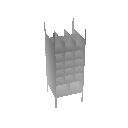

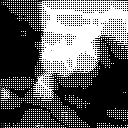

done
training...
   augmenting for training...
   done
[ 9.31985855  5.28874636  9.31985855  6.54048634  7.79171562  7.43048191
  5.37452459  7.79171562  6.80991554  8.99010944]
(10, 128, 128, 1)


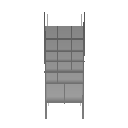

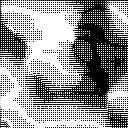

[  3.07798719   9.16456985   6.62287474  10.55877399   6.27190351
   1.19633174   6.6281929    8.79535961   9.70565128   4.37101603]
(10, 128, 128, 1)


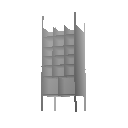

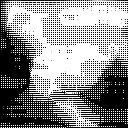

[  4.06204796   6.75374889   9.17889023   7.64721775   5.52638531
   8.62103462  11.25216103   4.86599731   3.50305271   9.39910507]
(10, 128, 128, 1)


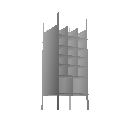

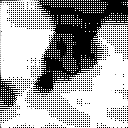

[  8.66412926   5.52740097   7.10709715  10.83853817   5.67679214
  10.02123642   4.11190462   4.81060219   7.87112427   1.68727064]
(10, 128, 128, 1)


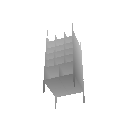

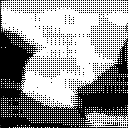

[ 10.44639778   5.03722382   9.05421257   4.31923294   2.61264729
  11.26642418   4.49724388   4.55567455   5.83304453   5.97429371]
(10, 128, 128, 1)


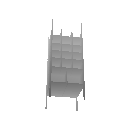

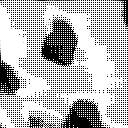

[  7.49759102   1.05716097   7.57426596  10.64650631  11.0830555
   3.67784572   5.62348461   4.7836113   10.84950352   7.77608967]
(10, 128, 128, 1)


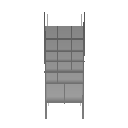

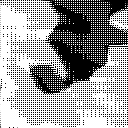

done
training...
   augmenting for training...
   done
[  8.6733427    7.71165276   5.42710543   7.74263954  10.22005081
   5.81616306   2.81868076   9.48332787   6.24796343   9.48332787]
(10, 128, 128, 1)


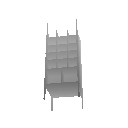

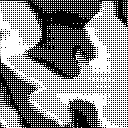

[  3.5776093    9.98917675   2.74444437   2.37886047  10.49650574
  10.44157028   5.85537148  10.48980141   6.40660763   4.4421134 ]
(10, 128, 128, 1)


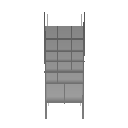

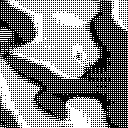

[ 9.75520039  3.73720288  8.88170147  7.48285198  6.39821577  6.26361084
  9.28362179  8.26818085  3.97445583  7.67303085]
(10, 128, 128, 1)


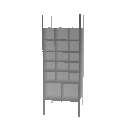

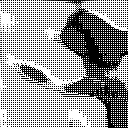

[ 5.89205217  8.04787254  9.13415146  9.50966549  2.24966097  5.72139549
  6.76037216  8.04787254  5.91232491  7.72842503]
(10, 128, 128, 1)


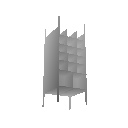

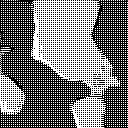

[  5.85404253  10.66418743   7.05239153   5.5081377    8.89819145
   8.24494553   6.37364101   6.15609169   5.85404253   5.5081377 ]
(10, 128, 128, 1)


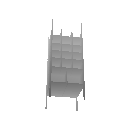

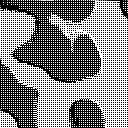

[ 9.46031094  2.66015363  1.18210292  8.5073595   8.95174503  6.20049429
  8.9335804   7.1835618   5.88538933  8.43079662]
(10, 128, 128, 1)


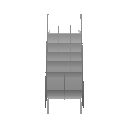

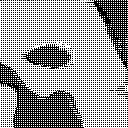

done
training...
   augmenting for training...
   done
[  4.70401478  11.34890366   3.62220025   3.62220025   7.05334902
   9.1015749    5.83310461   5.24928665   4.95820189   5.83310461]
(10, 128, 128, 1)


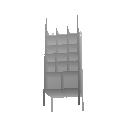

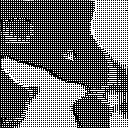

[  0.53592259   7.54018021   4.23506832  10.23608494   5.33014774
   7.64744329   8.71050739  10.95956039  10.50610542   8.38243675]
(10, 128, 128, 1)


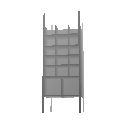

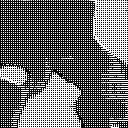

[ 11.21019363   4.228127     2.8900032    7.46595001   6.96332169
   5.52042103  10.33686256   9.36030197   8.75432205   2.1196208 ]
(10, 128, 128, 1)


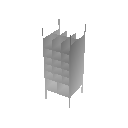

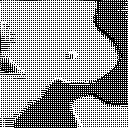

[  5.90709019   8.22930527  11.91893673   6.1362052    6.03094769
   5.90709019   6.55745459   5.24540663   8.93581772   9.26576996]
(10, 128, 128, 1)


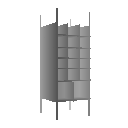

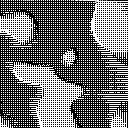

[  8.39347744   2.68562508  10.25132561   6.47867441   9.32951927
  10.46934223   3.95301509   7.10864067   5.20731068   8.47142696]
(10, 128, 128, 1)


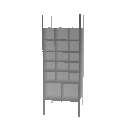

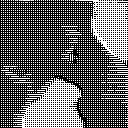

[  8.68008423  11.54805183   5.82755756   4.44746113   4.44746113
   7.28707552   3.3595407    5.7063694    9.95092964   8.11764145]
(10, 128, 128, 1)


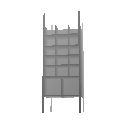

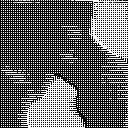

done
training...
   augmenting for training...
   done
[ 8.88843822  9.19801617  7.67296886  7.27311993  9.02289867  2.198843
  8.66163158  5.41693211  8.84820843  4.75608301]
(10, 128, 128, 1)


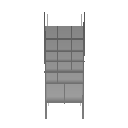

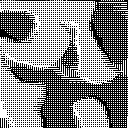

[ 6.50900984  6.09643316  3.86114669  7.05388594  9.69585514  9.72866344
  9.24681473  9.24681473  4.8185792   6.77522707]
(10, 128, 128, 1)


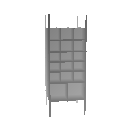

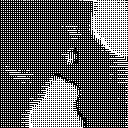

[  8.86751842  11.88219738   8.07009411   7.71916676   7.71916676
   3.91792655   9.56451416   6.6261487    6.07936239   6.7071023 ]
(10, 128, 128, 1)


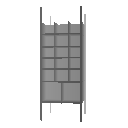

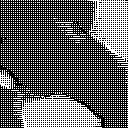

[ 8.27413654  8.87572002  6.36553097  5.84145021  8.18294144  5.22706604
  9.53222752  9.0818224   5.84145021  9.0818224 ]
(10, 128, 128, 1)


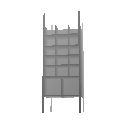

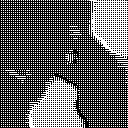

[  3.4501152    3.4501152    7.15959072   9.58551025   3.64463067
   8.43036366   8.08460045  10.74967098   5.86884308   8.6946106 ]
(10, 128, 128, 1)


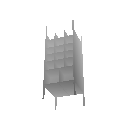

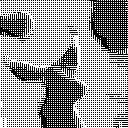

[  6.41706419   5.24456835   6.07646561  12.40774155   8.31749058
   7.19529915   7.54899263   6.41706419   9.29612541   7.37236023]
(10, 128, 128, 1)


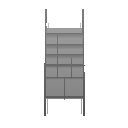

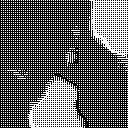

done
training...
   augmenting for training...
   done
[ 9.2988224   5.50355816  6.94002867  8.74900818  7.49777031  4.80463362
  4.80463362  9.67969036  9.68893623  7.12066507]
(10, 128, 128, 1)


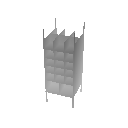

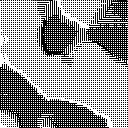

[  5.92098665   5.92098665   5.54983044   4.48399544   9.63850975
  10.99567699   6.78421736  10.60678959   5.54983044   8.00181198]
(10, 128, 128, 1)


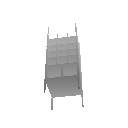

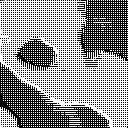

[  3.38092852   9.79070663   5.91553688   5.84179878   8.76811886
   7.11630726   5.88481426   3.79648972  10.67607117  10.14171886]
(10, 128, 128, 1)


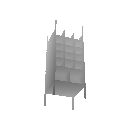

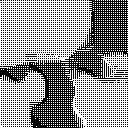

[ 9.34193802  6.31628132  9.70920849  9.74899769  6.71014547  8.39430904
  6.00896072  3.0122788   8.20576859  6.65021086]
(10, 128, 128, 1)


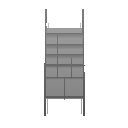

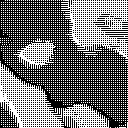

[  3.36874032   6.1225853    7.59856653   7.45805836   3.36874032
   8.02216434   7.37599993  12.16499233   4.78476429  12.23764133]
(10, 128, 128, 1)


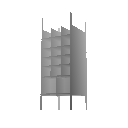

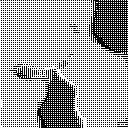

[  7.17316055  12.44214249  11.71517372   6.33218813   3.33350253
   9.01972198   6.71196842   3.21853542   3.33350253   8.64646626]
(10, 128, 128, 1)


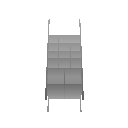

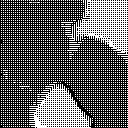

done
training...
   augmenting for training...
   done
[ 10.23449039   6.0681529    4.83415413   9.55224037   8.96872139
  12.41130638   3.26738405   7.91378736   3.26738405   7.41808605]
(10, 128, 128, 1)


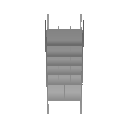

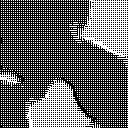

[  6.83706951   3.58400512   9.09521198   1.42290652   9.09521198
   8.30640602  11.78824139  12.33458996   5.37855339   4.19759798]
(10, 128, 128, 1)


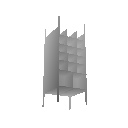

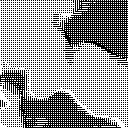

[  8.25044727   7.2950716    8.94620132   7.06453657   8.81895828
   4.26309538  11.85450554   7.40273523   7.22036982   4.72700357]
(10, 128, 128, 1)


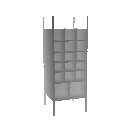

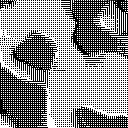

[  2.48047781   9.2922163    8.66828442   6.43813801   8.92494488
   7.78031969   5.86686659   6.43813801  12.38051033   2.28944612]
(10, 128, 128, 1)


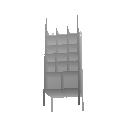

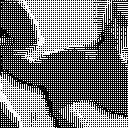

[  8.89757729   5.04249287   6.25390673  10.14138699  11.09342289
   7.12131453   9.39687634   5.04249287   2.33199263   6.32706213]
(10, 128, 128, 1)


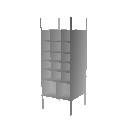

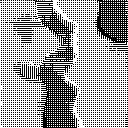

[ 8.67839527  7.58544588  8.28256607  9.26187992  6.21956778  9.43978024
  8.95861721  8.59354973  1.75677562  5.41589642]
(10, 128, 128, 1)


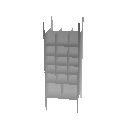

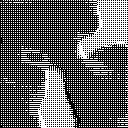

done
training...
   augmenting for training...
   done
[  0.29324391   6.53868866   7.93159962   5.28342152   7.90025902
   6.78409576   8.54276276  10.89989281   7.90314579   7.90314579]
(10, 128, 128, 1)


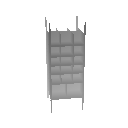

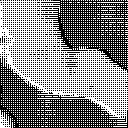

[ 11.88362026   6.39416075   8.283041     7.17212439  10.7863102
   8.25079441   8.283041     3.25516605   5.89087677   5.84095573]
(10, 128, 128, 1)


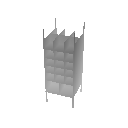

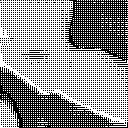

[  9.28698826   3.31328702   8.12843323   3.31328702  10.16868496
   9.09413052   9.37476635  10.13397312   5.32875347   5.59748745]
(10, 128, 128, 1)


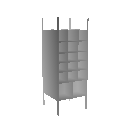

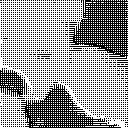

[ 6.3458643   8.23952866  5.97037983  9.33354759  8.76136494  7.56224108
  9.66892719  5.04046059  6.90748644  9.5342865 ]
(10, 128, 128, 1)


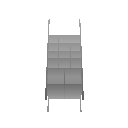

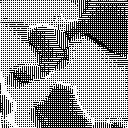

[ 6.58361864  9.22010326  9.39901924  8.23860168  6.24996424  7.10061932
  6.58361864  1.90648246  9.22386074  9.42959595]
(10, 128, 128, 1)


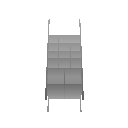

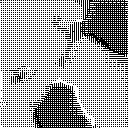

[ 12.17515659   1.51614797   7.47864389   6.91791248   9.43116379
   7.26199818   2.73759055   4.1849699    8.26640415  12.19426918]
(10, 128, 128, 1)


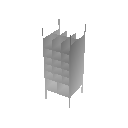

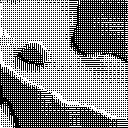

done
training...
   augmenting for training...
   done
[  8.87586021   8.59869766   5.17698669   5.94189787   9.53251362
   1.1644417    1.74945545  10.30611038  11.06276703   6.3522377 ]
(10, 128, 128, 1)


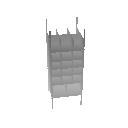

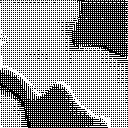

[ 7.7112031   5.44614506  7.32112026  5.95502377  9.96956635  6.8337326
  9.92125416  9.69064617  5.44614506  9.20964909]
(10, 128, 128, 1)


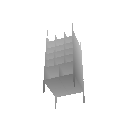

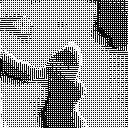

[  7.42239857   9.4307642    5.79068995  11.99868011   8.96371841
   2.65871644   2.75388598   7.65295601  11.68865108   1.5227232 ]
(10, 128, 128, 1)


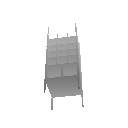

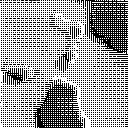

[  8.18979073  10.85481834   8.27009392   6.11328793   8.78098965
   4.84633207   9.57256889   5.31449032   2.9004786    9.49413872]
(10, 128, 128, 1)


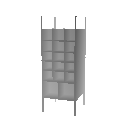

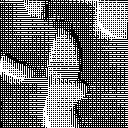

[ 10.80433941   1.60559988   6.59206772   9.49016571   9.7159462
   1.41237891   8.71923351   6.82767582   5.8802762    9.64528847]
(10, 128, 128, 1)


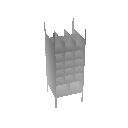

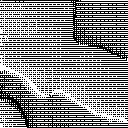

[ 6.62063551  2.72760296  4.36759806  8.88005924  9.93691444  9.52554226
  9.40957165  2.72760296  9.04580212  8.27465057]
(10, 128, 128, 1)


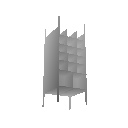

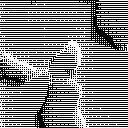

done
training...
   augmenting for training...
   done
[  9.40710545   8.74363708   7.8671174   10.06879139   3.49497366
   8.24953365   8.24953365   7.38778448   7.12973833   6.1332078 ]
(10, 128, 128, 1)


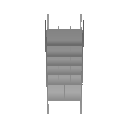

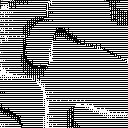

[  6.34551716   7.26568842   7.31636953  11.3600359    7.32859421
   7.31636953   9.31360626   6.55088377   8.84384155   3.78968072]
(10, 128, 128, 1)


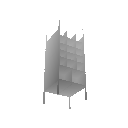

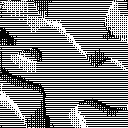

[  5.70887232   7.86750793   4.82301998   8.46508408  12.64995289
   9.14690876   5.55529213   5.55529213   5.70887232  11.1479578 ]
(10, 128, 128, 1)


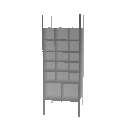

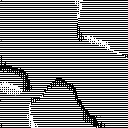

[ 9.47264194  8.20648479  4.62891531  6.27490759  7.77106619  8.84234715
  8.41912079  8.18975735  7.52258205  4.34980965]
(10, 128, 128, 1)


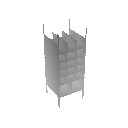

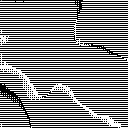

[  9.42894459   9.35418797   6.7318635    9.12597847   4.87860441
   6.665061     6.07673883   5.99765158   2.95045328  11.26637554]
(10, 128, 128, 1)


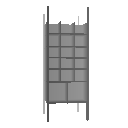

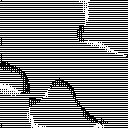

[  4.50181866   8.11684513   7.99611378   3.81635952  10.4059124
   3.81635952   9.25381756  10.86082935   8.88386154   5.15555477]
(10, 128, 128, 1)


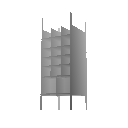

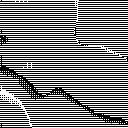

done
training...
   augmenting for training...
   done
[ 6.87286139  9.44320202  7.52938318  3.48160791  6.83827162  8.99519348
  8.29580307  8.99519348  8.75200176  7.27668953]
(10, 128, 128, 1)


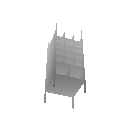

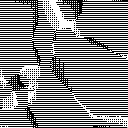

KeyboardInterrupt: 

In [7]:
training_epochs = 10
batch_size      = 10
# read the training data
path = config.path
file = 'shelf'
path_data = path + file + '.npz'
l = np.load(path_data)
print (l.files)

# Parse data
train_depth = l['depth_map']
#train_obj_pose = l['obj_pose']

# Training cycle
loss = []
error_train = []
error_test = []
training_epochs = 1000
for epoch in range(training_epochs):
    avg_cost = 0.
    test_acc = 0.
    print('training...')
    
    print('   augmenting for training...')
    train_depth_aug = np.empty([train_depth.shape[0], train_depth.shape[1], train_depth.shape[2], 1])
    for i in range(train_depth.shape[0]):
        img_aug = train_depth[i].reshape((train_depth[i].shape[0], train_depth[i].shape[1], 1))
        #img_aug = aug.augmentation(img=train_depth[i], aug_horz_max = 50, aug_vert_max = 50, aug_noise_max = 5, aug_const_max = 50)
        train_depth_aug[i] = img_aug
    print('   done')
    
    #ntrain = total size of training images
    ntrain = train_depth_aug.shape[0]
    # num_batch = number of batches needed
    # batch_size = images in each batch
    num_batch = int(ntrain/batch_size)+1
    
    
    #
    for i in range(num_batch): 
        randidx = np.random.randint(ntrain, size=batch_size)            
        batch_depth = train_depth_aug[randidx, :]        
        #print(batch_depth.shape, batch_mode.shape, batch_ang.shape, batch_output.shape)
        feed={x_in_depth: batch_depth,  phase:True}
        sess.run(optm, feed_dict=feed)
        # Compute average loss
        # cost = average cost for one complete batch
        # avg_cost = the average in each epoch
        avg_cost += sess.run(cost, feed_dict=feed)/num_batch
        fetches = [x_reconstructed, rec_loss, kl_loss]
        x_reconstructed_input, recons_loss, kl_d_loss  = sess.run(fetches, feed_dict=feed)
        print(kl_d_loss) 
        print(x_reconstructed_input.shape)
        display_img_array(batch_depth[0,:,:,0]*255)
        display_img_array(x_reconstructed_input[0,:,:,0])
        
        error_train.append(avg_cost)
        loss.append(avg_cost)
    print('done')


In [ ]:
#tf.shape(deconv4)
print(deconv4.get_shape())
print(deconv3.get_shape())

print(deconv2.get_shape())
#print(deconv1.get_shape())

In [ ]:
x_reconstructed.get_shape()